# Exercise 9 - Support Vector Machine

In this exercise you will implement a Support Vector Machine and enhance it using the Kernel Trick.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de

### Submission
- Deadline of submission:
        14.06.23 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=43681)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# The Dataset

In this exercise we are again using a toy [circle dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) from scikit learn.

### Task 1

Load and display the dataset using matplotlib, make sure to color the points according to their label.

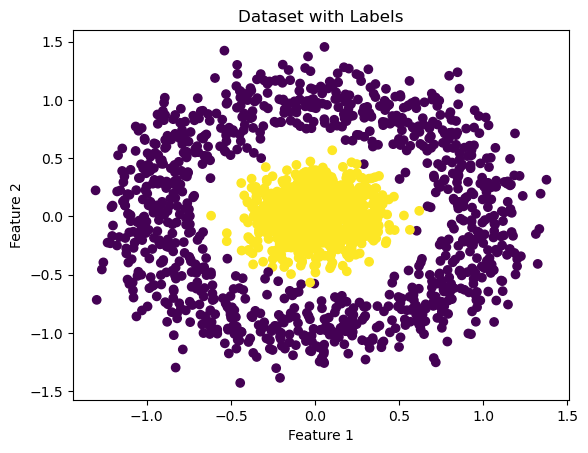

In [39]:
# TODO: load + display data
import numpy as np
import matplotlib.pyplot as plt


X = np.load('X.npy')
y = np.load('y.npy')

X = np.insert(X, 0, 1.0, axis=1)

plt.scatter(X[:, 1], X[:, 2], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Labels')
plt.show()



### Task 2

Last exercise we saw that using a polynomial Kernel allowed us to have non linear decision boundaries.

Use the functions and classes provided in `utils.py` to fit a logistic regressor with and without a polynomial kernel and visualize the decision boundaries.

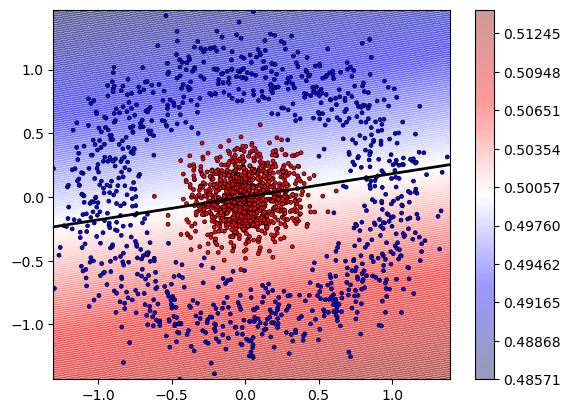

In [40]:
# TODO: fit and display logistic regression without kernel
from sklearn.linear_model import LogisticRegression
import utils

LogReg = utils.LogReg()
LogReg.fit(X, y)
utils.plot_dec_boundary(X, y, LogReg.get_probs)

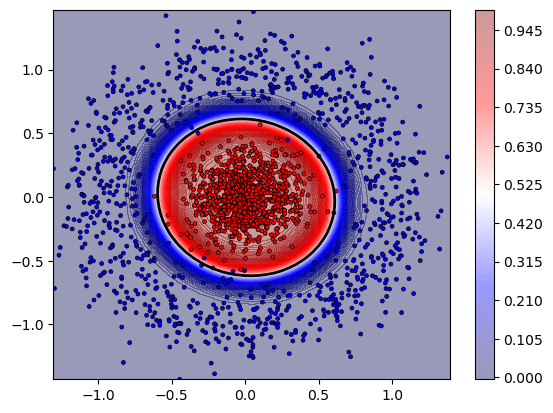

In [41]:
# TODO: fit and display logistic regression with kernel
LogRegPoly = utils.LogRegPoly(2)
LogRegPoly.fit(X, y)
utils.plot_dec_boundary(X, y, LogRegPoly.get_probs)

# Support Vector Machine (SVM)

The standard soft margin support vector machine is defined by the loss function:
\begin{align*}
L(X,Y,\theta) = \cfrac{1}{2}||\theta||^2+C\sum_{i=1}^m\max\{1-y^{(i)}(\theta^Tx^{(i)}), 0\}.
\end{align*}


As always the goal is to find a parameter vector $\theta$ and we can use the fact, that $\theta$ is a linear combination of the training datapoints (representer theorem, like in the last exercise)
\begin{align*}
\theta = \sum_{i=1}^m w_i x_{\text{train}}^{(i)} = w^T X_{\text{train}}
\end{align*}

to rewrite the objective function as:
\begin{align*}
L(X,Y,w, b) = \cfrac{1}{2}w^TX_{\text{train}}X_{\text{train}}^Tw+C\sum_{i=1}^m\max\{1-y^{(i)}(w^TX_{\text{train}}x^{(i)}+b), 0\}\,.
\end{align*}

Note that the labels $y^{(i)}$ have to be binary in $\{-1,1\}$.

This loss function relies on the dot product as a measure of similarity between two datapoints.
For two matrices $X_1\in\mathbb{R}^{m_1\times d}, X_2\in\mathbb{R}^{m_2\times d}$, we call the matrix of pairwise similarity $c = X_1X_2^T\in\mathbb{R}^{m_1\times m_2}$

This leads to:
$$
L(X,Y,w, b) = \cfrac{1}{2}w^T\operatorname{Sim}\left(X_{\text{train}}, X_{\text{train}}\right)w+C\sum_{i=1}^m\max\left\{1-y^{(i)}\left(w^T\operatorname{Sim}\left(X_{\text{train}}, x^{(i)}\right)+b\right), 0\right\}\,.
$$


### Task 3

Implement the pairwise similarity function for dot products. We will use this similarity function everytime we have a dot product between two datapoints.

In [42]:
def sim_dot(X1 : np.ndarray, X2 : np.ndarray) -> np.ndarray:
    '''
    Similarity as dot product.
    
    @Params:
        X1... set of samples (m1 x d)
        X2... set of samples (m2 x d)
        
    @Returns:
        similarity matrix (m1 x m2)
    '''
    # TODO: Implement similarity function as dot products between two sets of vectors
    return X1 @ X2.T


# TODO: make sure assertions pass
x0 = np.array([[1,2,3],[4,5,6],[7,8,9]])
x1 = np.array([[2,3,4],[1,2,3]])
assert np.all(sim_dot(x0, x1) == np.array([[20, 14],[47, 32],[74, 50]])) 



Lets have a closer look at the second part of our loss function $L$:

The innermost component 

$$
\operatorname{Dec}(x):= w^TX_{\text{train}}x+b = w^T \operatorname{Sim}(X_{\text{train}},x)+b
$$

produces a *decision* of the SVM that can be used for a *prediction*

$$
\hat{y}=\operatorname{Pred}(x) := \begin{cases}
1\text{, if }\operatorname{Dec}(x)\geq 0\\
-1\text{, else}
\end{cases}
$$

for the label $\hat{y}$ of the sample $x$.

Next, we multiply this decision with the true label. 
$$
\operatorname{Marg}(x):=y\operatorname{Dec}(x) %= y(w^TX_{\text{train}}x+b)
$$

This term is called *margin*.

Recall, that our true labels are $\in\{-1,1\}$. Therefore
$$
\max\{1-\operatorname{Marg}(x), 0\} = \begin{cases}
0&\text{, if }\operatorname{sign}(\operatorname{Dec}(x))=\operatorname{sign}(y)\text{ and }|\operatorname{Dec}(x)|\geq 1&\text{ we are correct and very certain}\\
\in(0,1]&\text{, if }\operatorname{sign}(\operatorname{Dec}(x))=\operatorname{sign}(y)\text{ and }|\operatorname{Dec}(x)|< 1&\text{ we are correct but not too certain}\\
\in(1,\infty)&\text{, if }\operatorname{sign}(\operatorname{Dec}(x))\neq \operatorname{sign}(y)&\text{ we are incorrect}\\
\end{cases}
$$

gives us a measure on the error we made with a decision.  The term

\begin{align*}
\xi_i := 1-\operatorname{Marg}\left(x^{(i)}\right)
\end{align*}
is called *slack*. This means our objective function aims to minimize the slack for all samples $x^{(i)} \in X_\text{train}$.

Note that we use a corpus of features $X$ (our trainingdata) to calculate the decision (and prediction) for other features.

### Task 4

Implement the loss function and the functions for decision, prediction, margin and slack. 

Implement these functions, so that everything is calculated for *multiple* new feature vectors $x$ at once. They should use a similarity matrix `sim` as defined above.

In [43]:
def decision(sim : np.ndarray, w : np.ndarray, b : float) -> np.ndarray:
    '''
    Decision of SVM.
    
    @Params:
        sim... similarity matrix between X_train and X
        w... parameter vector
        b... offset
        
    @Returns:
        decision values for each x in X
    '''
    # TODO: Implement decision function
    return w.T @ sim + b

def predict_svm(sim : np.ndarray, w : np.ndarray, b : float) -> np.ndarray:
    '''
    Prediction of SVM.
    
    @Params:
        sim... similarity matrix between X_train and X
        w... parameter vector
        b... offset
        
    @Returns:
        predicted labels for each x in X
    '''
    # TODO: Implement prediction function
    return [-1 if x < 0 else 1 for x in decision(sim, w, b)]

def margin(sim : np.ndarray, y : np.ndarray, w : np.ndarray, b : float) -> np.ndarray:
    '''
    Margin of SVM.
    
    @Params:
        sim... similarity matrix between X_train and X
        y... labels
        w... parameter vector
        b... offset
        
    @Returns:
        margin values for each x in X
    '''
    # TODO: Implement margin function
    return y * decision(sim, w ,b)

def slack(sim : np.ndarray, y : np.ndarray, w : np.ndarray, b : float) -> np.ndarray:
    '''
    Slack of SVM.
    
    @Params:
        sim... similarity matrix between X_train and X
        y... labels
        w... parameter vector
        b... offset
        
    @Returns:
        slack values for each x in X
    '''
    # TODO: Implement slack
    return 1-margin(sim, y, w, b)

def loss_svm(sim : np.ndarray, y : np.ndarray, w : np.ndarray, b : float, C : float) -> float:
    '''
    Loss function SVM.
    
    @Params:
        sim... similarity matrix between X_train and X
        y... labels
        w... parameter vector
        b... offset
        C... regularization parameter
    @Returns:
        Loss
    '''
    # TODO: Implement cost function
    return 0.5 * w.T @ sim @ w + C * np.sum(np.maximum(slack(sim, y, w, b), 0))



# TODO: make sure assertions pass
w = np.array([1,-3])
b = 2
C = 10.0
K = sim_dot(np.array([[1,0,1],[2,1,0]]),np.array([[1,1,1],[2,-1,1]]))
y_tmp = np.array([1,-1])
assert np.all(decision(K, w, b) == np.array([-5, -4]))
assert np.all(predict_svm(K, w, b) == np.array([-1, -1]))
assert np.all(margin(K, y_tmp, w, b) == np.array([-5, 4]))
assert loss_svm(K, y_tmp, w, b, C) == 65.5



Our goal is to minimize the loss function based on training data. We will do so by using gradient descend on the two optimizable parameters $w$ and $b$.

\begin{align}
\frac{d L}{d w}&=X_{\text{train}}X_{\text{train}}^Tw-C\sum_{i=1, \xi_i\geq 0}^m y_{\text{train}}^{(i)}X_{\text{train}}x^{(i)}\\
&= \operatorname{Sim}(X_\text{train},X_\text{train})w-C\sum_{i=1, \xi_i\geq 0}^m y_{\text{train}}^{(i)}\operatorname{Sim}\left(X_{\text{train}},x^{(i)}\right)\\
\frac{d L}{d b}&=-C\sum_{i=1, \xi_i\geq 0}^m y_{\text{train}}^{(i)}
\end{align}

To recall gradient descend, have a look at the last exercises or the `utils.LogReg` class. Also note that the gradients depend on the slack.

### Task 5
Implement functions that calculate the gradients with respect to $w$ and $b$. Again, use a precalculated `sim` matrix for computing the dot products between datapoints.

In [44]:
def grad_b(sim : np.ndarray, y : np.ndarray, w : np.ndarray, b : float, C : float) -> float:
    '''
    Gradient of Loss wrt. b.
    
    @Params:
        sim... similarity matrix between X_train and X_train
        y... labels of train data
        w... parameter vector
        b... offset
        C... regularization parameter
    @Returns:
        scalar gradient
    '''
    # TODO: Implement gradient wrt. b
    #tmp = 0
    
    #for i in range(len(y)):
    #    if (slack(sim, y, w, b)[i] >= 0):
    #        tmp += y[i] 
            
    tmp = np.sum(y[slack(sim, y, w, b) >= 0], axis=0)
            
    return -C * tmp


def grad_w(sim : np.ndarray, y : np.ndarray, w : np.ndarray, b : float, C : float) -> np.ndarray:
    '''
    Gradient of Loss wrt. b.
    
    @Params:
        sim... similarity matrix between X_train and X_train
        y... labels of train data
        w... parameter vector
        b... offset
        C... regularization parameter
    @Returns:
        vector gradient
    '''
    
    
    # TODO: Implement gradient wrt. w
    #tmp = 0
    
    #for i in range(len(y)):
    #    if (slack(sim, y, w, b)[i] >= 0):
    #        tmp += (y[i] * sim[i]) 
            
    tmp = np.sum(y[slack(sim, y, w, b) >= 0].reshape(-1, 1) * sim[slack(sim, y, w, b) >= 0], axis=0)
            
    return sim @ w - C * tmp

 

# TODO: make sure assertions pass
w = np.array([1,-3])
b = 2
C = 10.0
K = sim_dot(np.array([[1,0,1],[2,1,0]]),np.array([[1,1,1],[2,-1,1]]))
y_tmp = np.array([1,-1])
assert grad_b(K, y_tmp, w, b, C) == -10
assert np.all(grad_w(K, y_tmp, w, b, C) == np.array([-27., -36.]))



### Task 6

Implement the folowing `SVM` class. Fit a SVM on the training data and visualize the decision boundary.

To plot the decision boundary, we will need a function that returns probabilities.\
We do not really have this, so we just take the sigmoid of the decision function:

\begin{align*}
p(y = 1| x) = \sigma\left(\text{Dec}(x)\right)\,.
\end{align*}

Note: If the flag `use_K` is set, we want to predict the probabilities on the training data. Then we can use the Kernel matrix $K$ for the training data that we already calculated during fitting the model. This way we need to calculate $K$ only once during training.

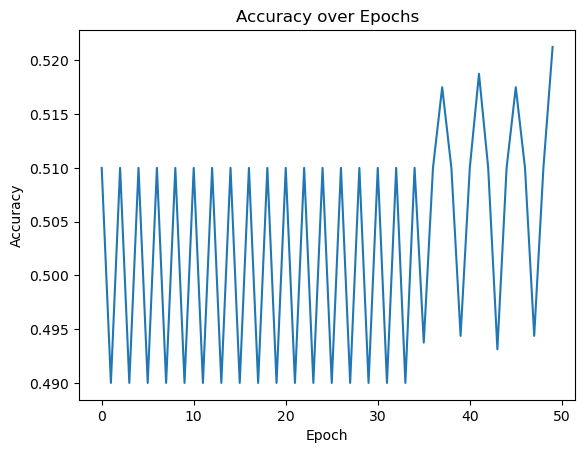

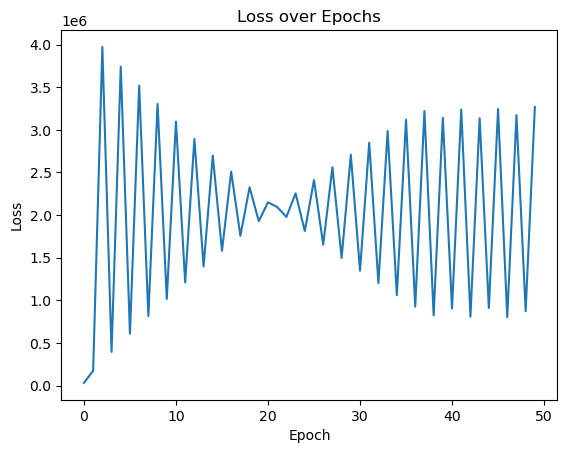

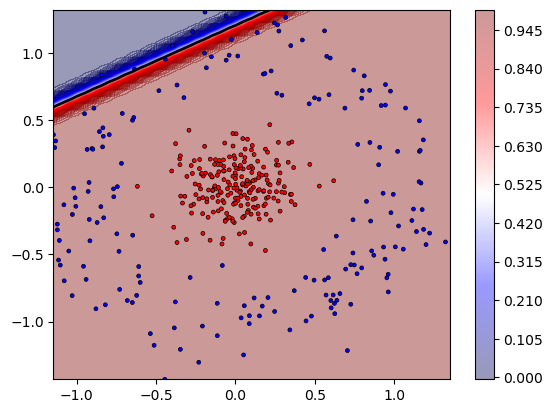

In [57]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

class SVM(BaseEstimator):

    def __init__(self, sim_func : callable):
        '''
        Class for SVM.
        
        @Params:
            sim_func... function that takes X0, X1 and outputs similarity matrix.
        '''
        self.sim_func = sim_func
        self.w = None # parameter vector
        self.b = None # offset
        self.X_train = None # Training samples
        self.K = None # Kernel matrix
        self.accs = [] # accuracies
        self.losses = [] # losses

    def score(self, X : np.ndarray, y : np.ndarray, use_K : bool = False) -> float:
        '''
        Accuracy of SVM.
        
        @Params:
            X... feature vectors
            y... labels
            use_K... if True, uses Kernel matrix of training data (no need to recompute). 
        
        @Returns:
            Accuracy
        '''
        # TODO: implement
        if not use_K:
            K = self.sim_func(self.X_train, X)
        else:
            K = self.K

        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def predict(self, X : np.ndarray, use_K : bool = False) -> np.ndarray:
        '''
        Predicts labels for given features
        
        @Params:
            X... feature vectors
            use_K... if True, uses Kernel matrix of training data (no need to recompute). 
        
        @Returns:
            label vector
        '''
        # TODO: implement
        if not use_K:
            K = self.sim_func(self.X_train, X)
        else:
            K = self.K
            
        return predict_svm(K, self.w, self.b)
    
    
    def get_probs(self, X, use_K : bool = False) -> np.ndarray:
        '''
        Predicts probabilities for given features
        
        @Params:
            X... feature vectors
            use_K... if True, uses Kernel matrix of training data (no need to recompute). 
            
        @Returns:
            label vector
        '''
        # TODO: implement
        if not use_K:
            K = self.sim_func(self.X_train, X)
        else:
            K = self.K

        decision_values = decision(K, self.w, self.b)
        return utils.sigmoid(decision_values)  
    
        
    def fit(self, X : np.ndarray, y : np.ndarray, C : float = 20, lr : float = 1e-5, max_it : int = 50, eps : float = 1e-1) -> None:       
        '''
        Gradient descend for SVM soft margin loss.

        @Params:
            X... matrix with datapoints as rows (m x n)
            y... array of true labels (n)
            C... regularization parameter
            lr... learnrate, sets stepsize for descend
            max_it... maximum number of steps
            eps... abort criterium for early stopping (loss did not change more than this)
        '''
        # TODO: implement
        self.w = np.zeros(X.shape[0])
        self.b = 0
        self.X_train = X
        self.K = self.sim_func(X, X)

        for it in range(max_it):
            loss = loss_svm(self.K, y, self.w, self.b, C)
            self.losses.append(loss)

            if it > 0 and np.abs(loss - self.losses[it - 1]) < eps:
                break

            self.w -= lr * grad_w(self.K, y, self.w, self.b, C)
            self.b -= lr * grad_b(self.K, y, self.w, self.b, C)

            acc = self.score(X, y, use_K=True)
            self.accs.append(acc)
                
                
# TODO: fit on trainset + visualize decision boundary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_linear = SVM(sim_dot)
svm_linear.fit(X_train, y_train, max_it = 50)

# Plot accuracies
plt.figure()
plt.plot(range(len(svm_linear.accs)), svm_linear.accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

# Plot losses
plt.figure()
plt.plot(range(len(svm_linear.losses)), svm_linear.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

utils.plot_dec_boundary(X_test, y_test, svm_linear.get_probs)


### Task 7

Now we want to use a polynomial kernel as similarity function again. We can do this with minimal code adjustments. In fact, you just need to provide `SVM` with a different function for the `sim_func` parameter. This similarity function should use the `kernel` method from the last exercise (you find it in `utils.py`) with a degree of 2. 

Fit the polynomial SVM (tune the hyperparameters if needed), and plot the accuracies and losses over the different epochs just as above. Finally visualize the result with `plot_dec_boundary`. 

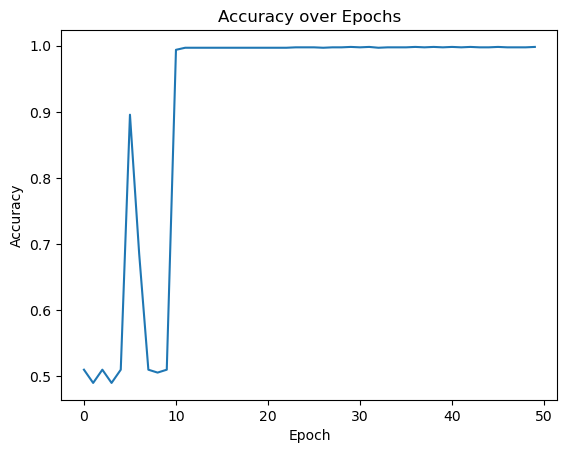

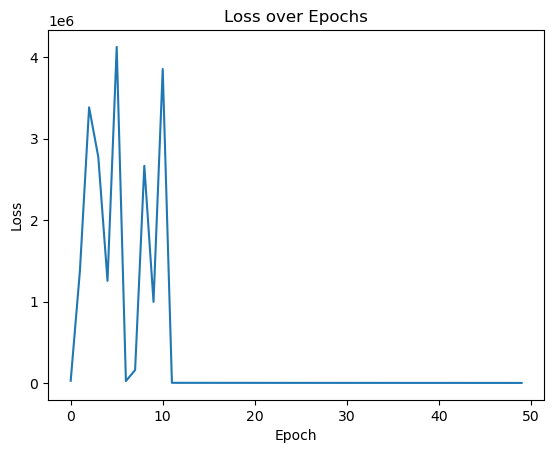

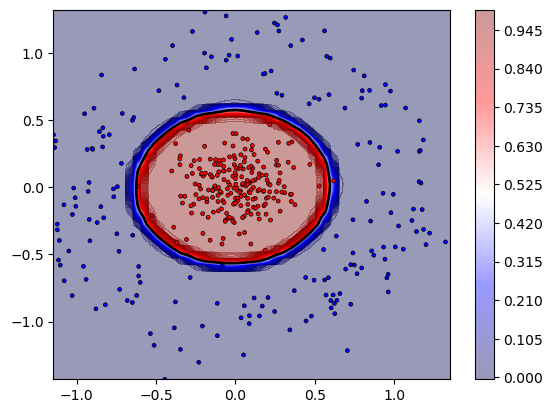

In [46]:
# TODO: fit polynomial SVM + visualize decision boundary
def poly_kernel(X1 : np.ndarray, X2 : np.ndarray, d : int = 2) -> np.ndarray:
    '''
    Calculates polynomial kernel matrix. 

    @Params:
        X1... sample matrix (m1 x d)
        X2... sample matrix (m2 x d)
        d... polynomial degree

    @Returns:
        Kernel matrix (m1 x m2)
    '''
    return (X1 @ X2.T) ** d

svm_poly = SVM(poly_kernel)
svm_poly.fit(X_train, y_train)

# Plot accuracies
plt.figure()
plt.plot(range(len(svm_poly.accs)), svm_poly.accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

# Plot losses
plt.figure()
plt.plot(range(len(svm_poly.losses)), svm_poly.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

utils.plot_dec_boundary(X_test, y_test, svm_poly.get_probs)

### Task 8

How does the regularization parameter `C` affect the results? Test out different values and write down what you observe.

In [47]:
# TODO: what effect does C have?
C = [1, 2, 4, 8, 16, 32, 64]

accuracy_linear = []
for c in C:
    svm_linear.fit(X_train, y_train, C = c)
    accuracy_linear.append(svm_linear.score(X_test, y_test))
    
print(accuracy_linear)

accuracy_poly = []
for c in C:
    svm_poly.fit(X_train, y_train, C = c)
    accuracy_poly.append(svm_poly.score(X_test, y_test))
    
print(accuracy_poly)

[0.46, 0.5575, 0.5575, 0.5575, 0.5525, 0.5525, 0.5525]
[0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995]


### Task 11

Use Crossvalidation to evaluate the performance of the SVM.

In [48]:
# TODO: assess performance with crossvalidation (10 folds)
from sklearn.model_selection import cross_val_score

# Create logistic regression model
model = SVM(poly_kernel)
model.fit(X_train, y_train)

# Perform cross-validation with 10 folds
scores = cross_val_score(model, X_test, y_test, cv=10)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [1.   1.   1.   1.   1.   1.   0.95 1.   1.   1.  ]
Mean accuracy: 0.9949999999999999


### Task 12

Compare your results with the [scikit learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [52]:
# TODO: Use sklearn to fit svm on traindata

from sklearn.svm import SVC

# Fit scikit-learn's SVM on the training data
svm_sklearn = SVC(kernel='poly', degree=2)
svm_sklearn.fit(X_train, y_train)

svm = SVM(poly_kernel)
svm.fit(X_train, y_train)

# Evaluate scikit-learn's SVM on the test data
accuracy_sklearn = svm_sklearn.score(X_test, y_test)
print("Scikit-learn SVM accuracy:", accuracy_sklearn)

# Evaluate your SVM implementation on the test data
accuracy_custom = svm.score(X_test, y_test)
print("Custom SVM accuracy:", accuracy_custom)

Scikit-learn SVM accuracy: 0.995
Custom SVM accuracy: 0.9975
